# Food classifier

## 1. Download the Food101 dataset if it does not exist

In [1]:
from pathlib import Path
import requests
import os
import tarfile
import json
import torch
import torchvision
import torchvision.models
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import helpers
from torchinfo import summary


In [2]:
# Setup device agnostic code :
device = torch.device(
    "mps" if (torch.backends.mps.is_available()) else "cuda" if torch.backends.cuda.is_built() else "cpu")
device

device(type='mps')

In [3]:

DATA_PATH = Path("data")
FOOD_101_PATH = DATA_PATH / "Food101"
FOOD_101_IMAGES_PATH = FOOD_101_PATH / "food-101/images"
FOOD_101_META_PATH = FOOD_101_PATH / "food-101/meta"
if FOOD_101_PATH.is_dir():
    print(f"The data directory {FOOD_101_PATH} already exists, skipping download...")
else:
    print(f"Downloading Food101 Data to {FOOD_101_PATH}")
    archive_filename = "food-101.tar.gz"
    os.makedirs(FOOD_101_PATH, exist_ok=True)
    request = requests.get("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz")
    with open(FOOD_101_PATH / archive_filename, "wb") as f:
        f.write(request.content)



The data directory data/Food101 already exists, skipping download...


### 1.1 Move the files into correct structure

In [4]:
def extract_and_move_food_101_files(archive_filename, num_of_classes: int = 10):
    with tarfile.open(FOOD_101_PATH / archive_filename) as ark:
        ark.extractall(FOOD_101_PATH)
    with open(FOOD_101_META_PATH / "test.json", "r") as f:
        test_json = json.load(f)
    num = 0
    for key in test_json:
        if num == num_of_classes:
            break
        for f in test_json[key]:
            try:
                os.renames(old=FOOD_101_IMAGES_PATH / (f + ".jpg"), new=FOOD_101_PATH / "test" / (f + ".jpg"), )
            except:
                print(f"Could not move {f}")
        num += 1

    with open(FOOD_101_META_PATH / "train.json", "r") as f:
        train_json = json.load(f)
    num = 0
    for key in train_json:
        if num == num_of_classes:
            break
        for f in train_json[key]:
            try:
                os.renames(old=FOOD_101_IMAGES_PATH / (f + ".jpg"), new=FOOD_101_PATH / "train" / (f + ".jpg"), )
            except:
                print(f"Could not move {f}")
        num += 1

#extract_and_move_food_101_files("food-101.tar.gz", 10)

## 2. Load the data into DataSets, and then turn that into DataLoaders

In [5]:
image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])
train_dataset = ImageFolder(root=str(FOOD_101_PATH / "train"), transform=image_transform)
test_dataset = ImageFolder(root=str(FOOD_101_PATH / "test"), transform=image_transform)

['beef_tartare', 'churros', 'foie_gras', 'greek_salad', 'hot_and_sour_soup', 'panna_cotta', 'pork_chop', 'samosa', 'sashimi', 'spring_rolls']


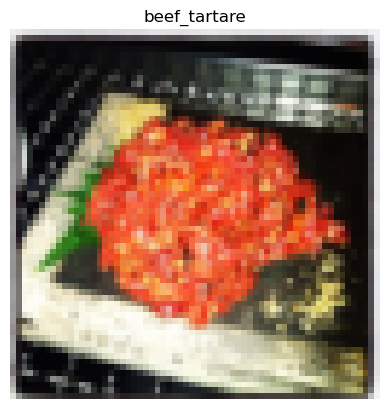

In [6]:
classes = train_dataset.classes
print(classes)
plt.title(classes[train_dataset[0][1]])
plt.axis(False)
plt.imshow(train_dataset[0][0].permute(1, 2, 0))

In [7]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### 2.1 Take a look at some data

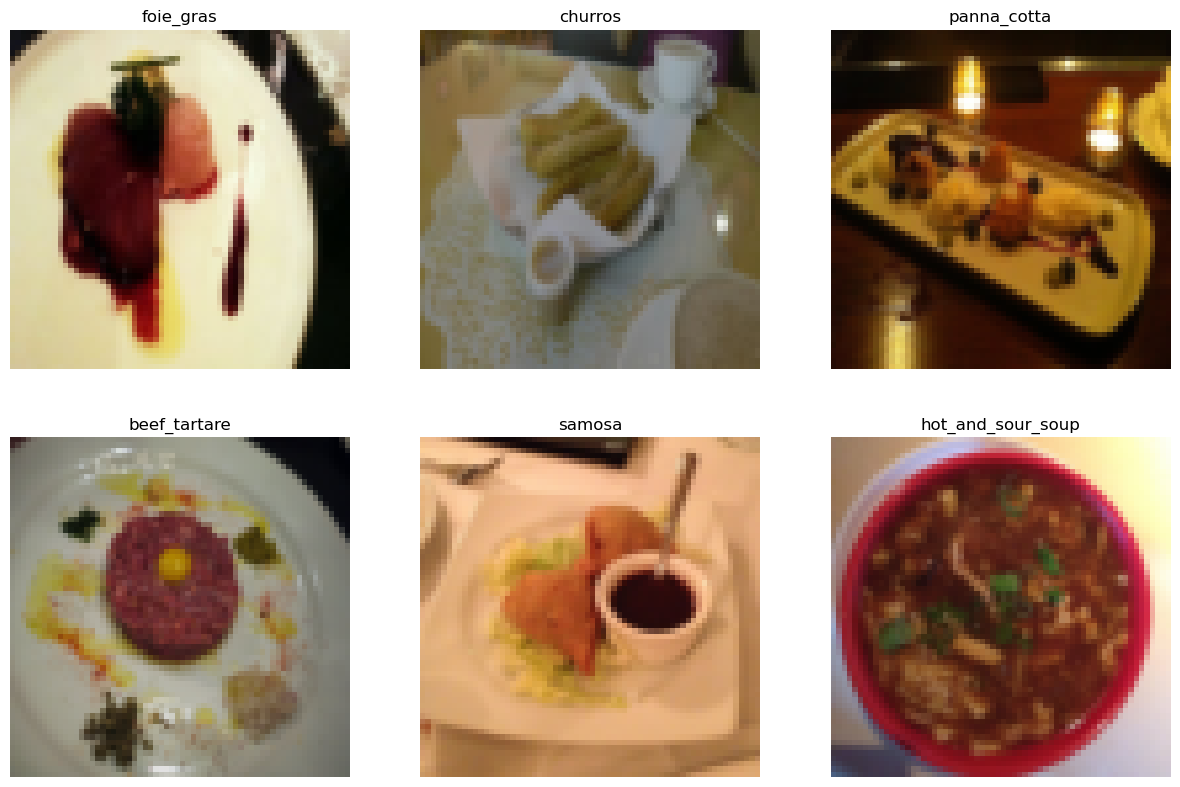

In [8]:
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(15, 15))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.axis(False)
    plt.title(classes[labels[i]])
    plt.imshow(images[i].permute(1, 2, 0))

## 3. Create a model based on TinyVGG architecture

In [9]:
class ModelV0(torch.nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 13 * 13,
                out_features=output_shape
            )
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        # This below will be faster! As the data does not go back to memory, instead all operations are done together; this is called operator fusion.
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model0 = ModelV0(input_shape=3,
                 hidden_units=10,
                 output_shape=len(classes)).to(device)

In [10]:
model0.eval()
model0(images[0].unsqueeze(dim=0).to(device))

tensor([[ 0.0212,  0.0375,  0.0211, -0.0614,  0.0825, -0.0307,  0.0457,  0.0367,
          0.0537,  0.0447]], device='mps:0', grad_fn=<LinearBackward0>)

In [11]:
from tqdm.auto import tqdm

results = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters())
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=model0, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=model0, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_accuracy)

    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_accuracy)

  0%|          | 0/3 [00:00<?, ?it/s]

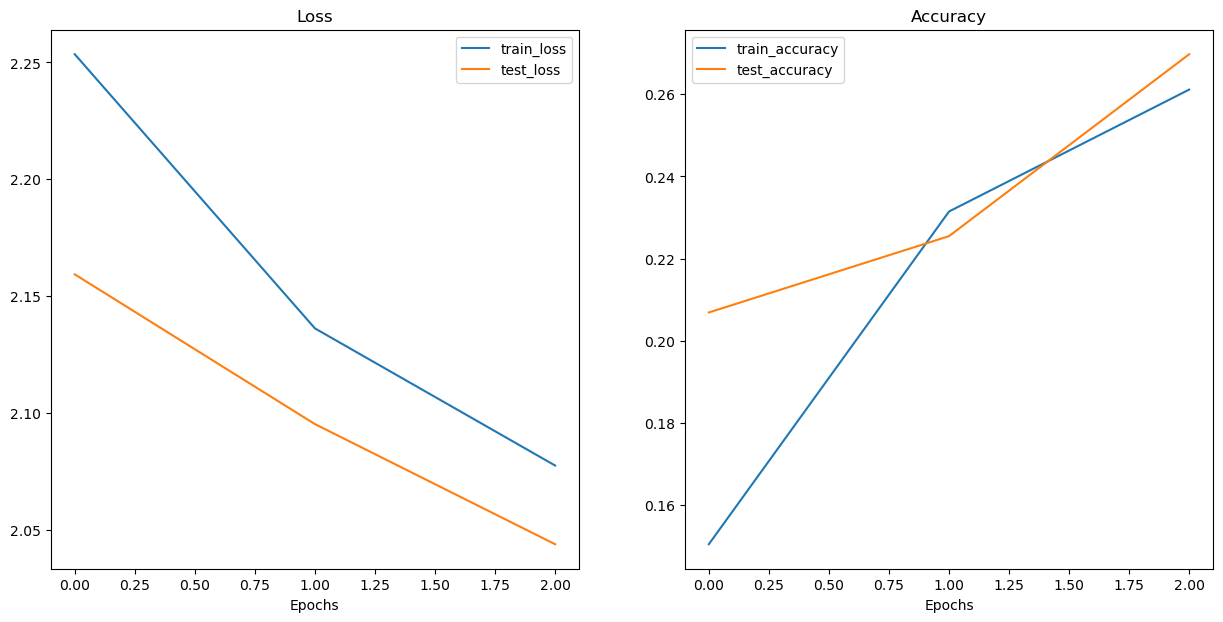

In [12]:
helpers.plot_loss_curves(results=results)

  0%|          | 0/3 [00:00<?, ?it/s]

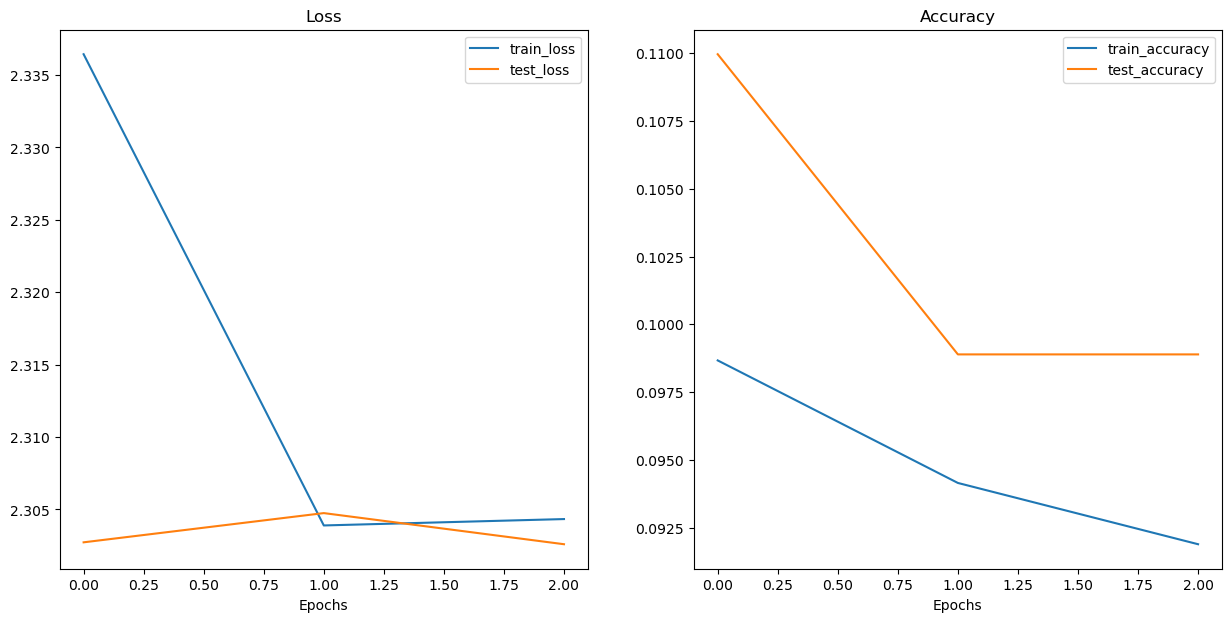

In [13]:
model0_2 = ModelV0(input_shape=3,
                   hidden_units=50,
                   output_shape=len(classes)).to(device)

results_model_0_2 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0_2.parameters(), lr=0.01)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=model0_2, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=model0_2, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_0_2["train_loss"].append(train_loss)
    results_model_0_2["train_accuracy"].append(train_accuracy)

    results_model_0_2["test_loss"].append(test_loss)
    results_model_0_2["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_0_2)


  0%|          | 0/3 [00:00<?, ?it/s]

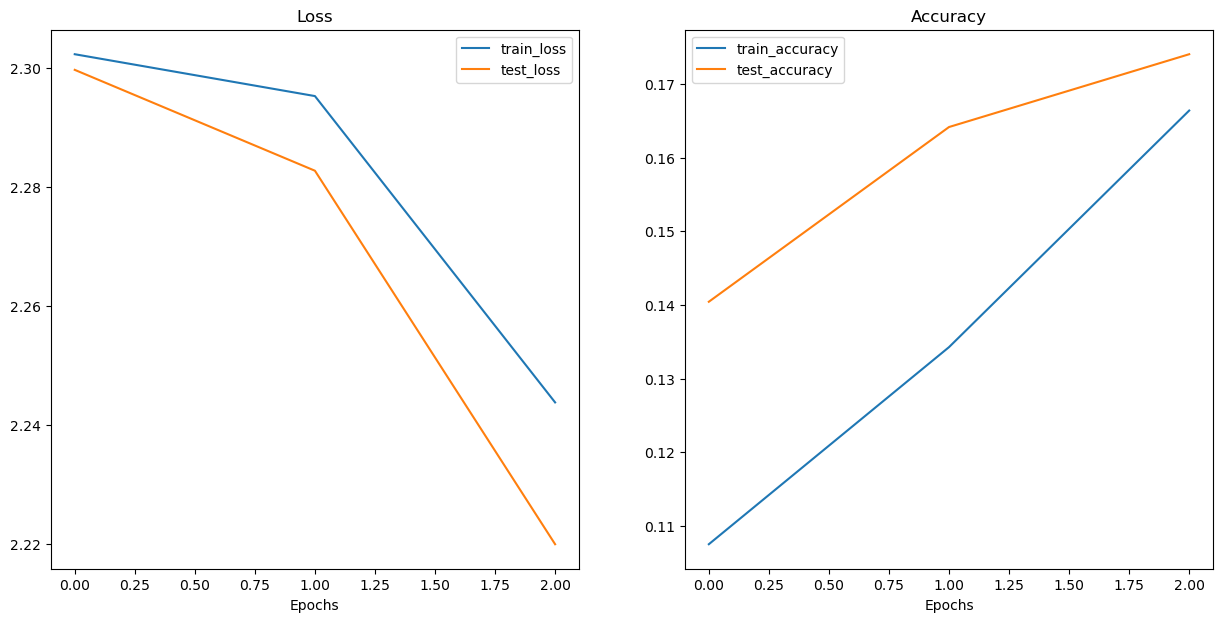

In [14]:
model_0_3 = ModelV0(input_shape=3,
                    hidden_units=50,
                    output_shape=len(classes)).to(device)
from tqdm.auto import tqdm

results_model_0_3 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0_3.parameters(), lr=0.01)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=model_0_3, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=model_0_3, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_0_3["train_loss"].append(train_loss)
    results_model_0_3["train_accuracy"].append(train_accuracy)

    results_model_0_3["test_loss"].append(test_loss)
    results_model_0_3["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_0_3)

In [15]:
from torchinfo import summary

summary(model0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
ModelV0                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [16]:
summary(model_0_3, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
ModelV0                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 50, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 50, 62, 62]           1,400
│    └─ReLU: 2-2                         [1, 50, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 50, 60, 60]           22,550
│    └─ReLU: 2-4                         [1, 50, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 50, 30, 30]           --
├─Sequential: 1-2                        [1, 50, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 50, 28, 28]           22,550
│    └─ReLU: 2-7                         [1, 50, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 50, 26, 26]           22,550
│    └─ReLU: 2-9                         [1, 50, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 50, 13, 13]           --


  0%|          | 0/3 [00:00<?, ?it/s]

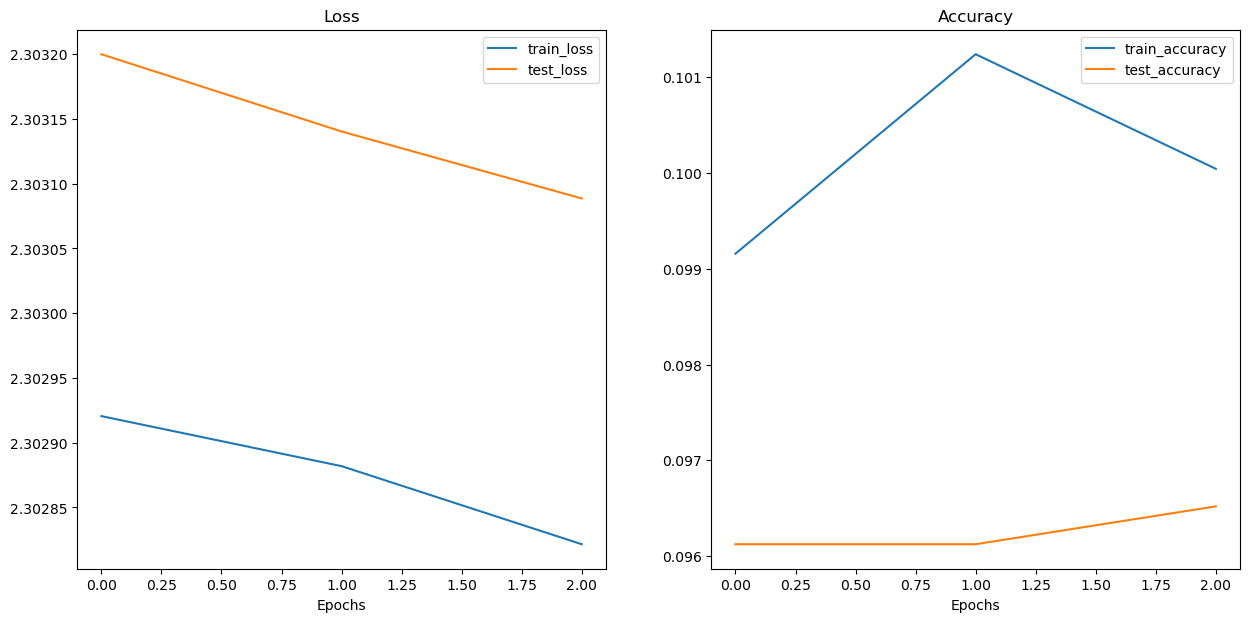

In [17]:
model_0_4 = ModelV0(input_shape=3,
                    hidden_units=10,
                    output_shape=len(classes)).to(device)
from tqdm.auto import tqdm

results_model_0_4 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0_4.parameters())
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=model_0_4, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=model_0_4, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_0_4["train_loss"].append(train_loss)
    results_model_0_4["train_accuracy"].append(train_accuracy)

    results_model_0_4["test_loss"].append(test_loss)
    results_model_0_4["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_0_4)

In [18]:
class ModelV1(torch.nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 4 * 4,
                out_features=output_shape
            )
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.conv_block_3(x)
        # print(x.shape)
        # x = self.classifier(x)
        # print(x.shape)
        # return x
        # This below will be faster! As the data does not go back to memory, instead all operations are done together; this is called operator fusion.
        return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))




  0%|          | 0/3 [00:00<?, ?it/s]

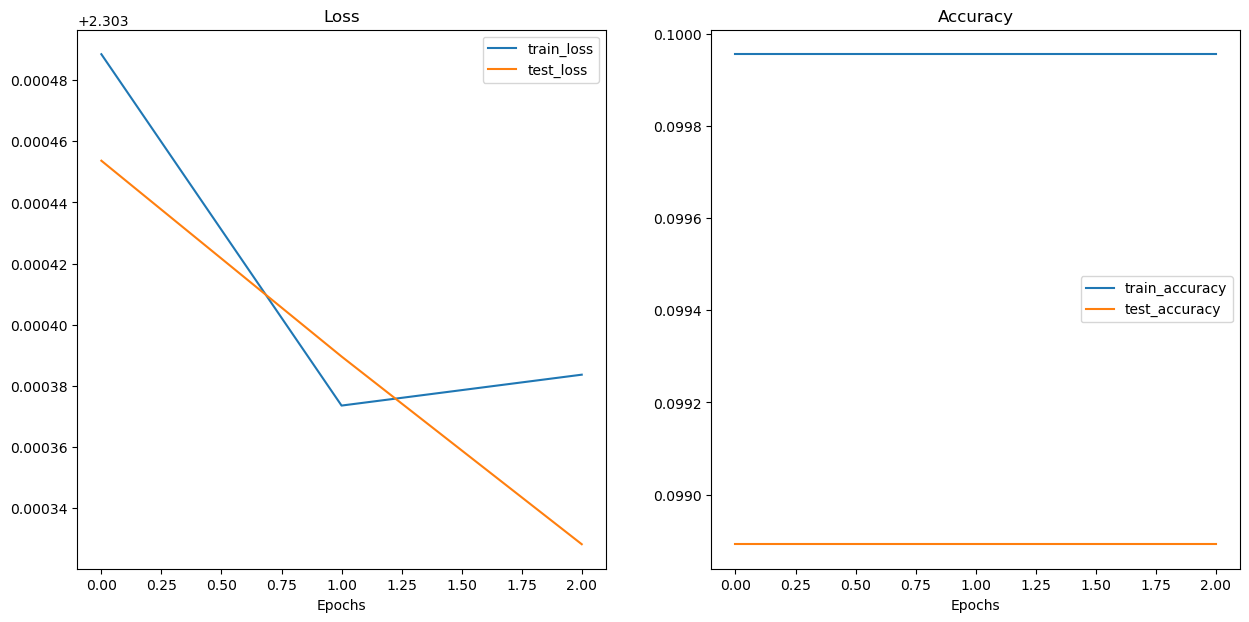

In [19]:
modelv1_1 = ModelV1(input_shape=3,
                    hidden_units=10,
                    output_shape=len(classes)).to(device)
from tqdm.auto import tqdm

results_model_v1_1 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelv1_1.parameters())
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=modelv1_1, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=modelv1_1, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_v1_1["train_loss"].append(train_loss)
    results_model_v1_1["train_accuracy"].append(train_accuracy)

    results_model_v1_1["test_loss"].append(test_loss)
    results_model_v1_1["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_v1_1)

  0%|          | 0/3 [00:00<?, ?it/s]

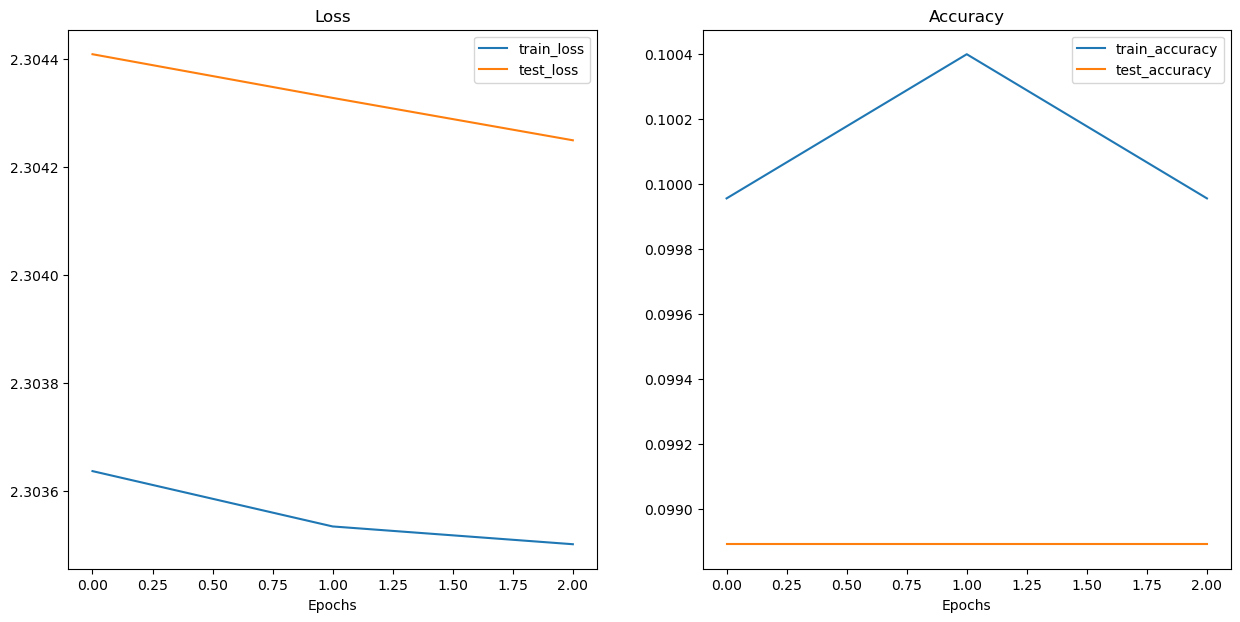

In [20]:
modelv1_2 = ModelV1(input_shape=3,
                    hidden_units=10,
                    output_shape=len(classes)).to(device)
from tqdm.auto import tqdm

results_model_v1_2 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelv1_2.parameters())
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=modelv1_2, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=modelv1_2, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_v1_2["train_loss"].append(train_loss)
    results_model_v1_2["train_accuracy"].append(train_accuracy)

    results_model_v1_2["test_loss"].append(test_loss)
    results_model_v1_2["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_v1_2)

  0%|          | 0/3 [00:00<?, ?it/s]

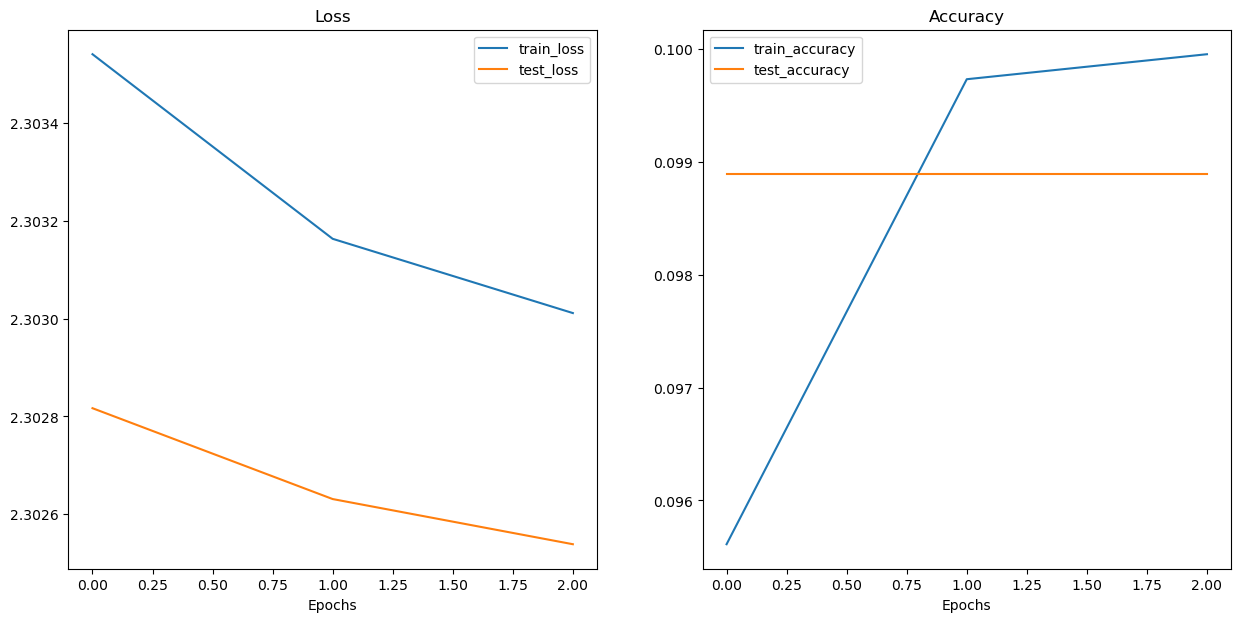

In [21]:
modelv1_3 = ModelV1(input_shape=3,
                    hidden_units=10,
                    output_shape=len(classes)).to(device)
from tqdm.auto import tqdm

results_model_v1_3 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelv1_3.parameters(), lr=0.001, momentum=0.9)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=modelv1_3, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=modelv1_3, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_v1_3["train_loss"].append(train_loss)
    results_model_v1_3["train_accuracy"].append(train_accuracy)

    results_model_v1_3["test_loss"].append(test_loss)
    results_model_v1_3["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_v1_3)

  0%|          | 0/3 [00:00<?, ?it/s]

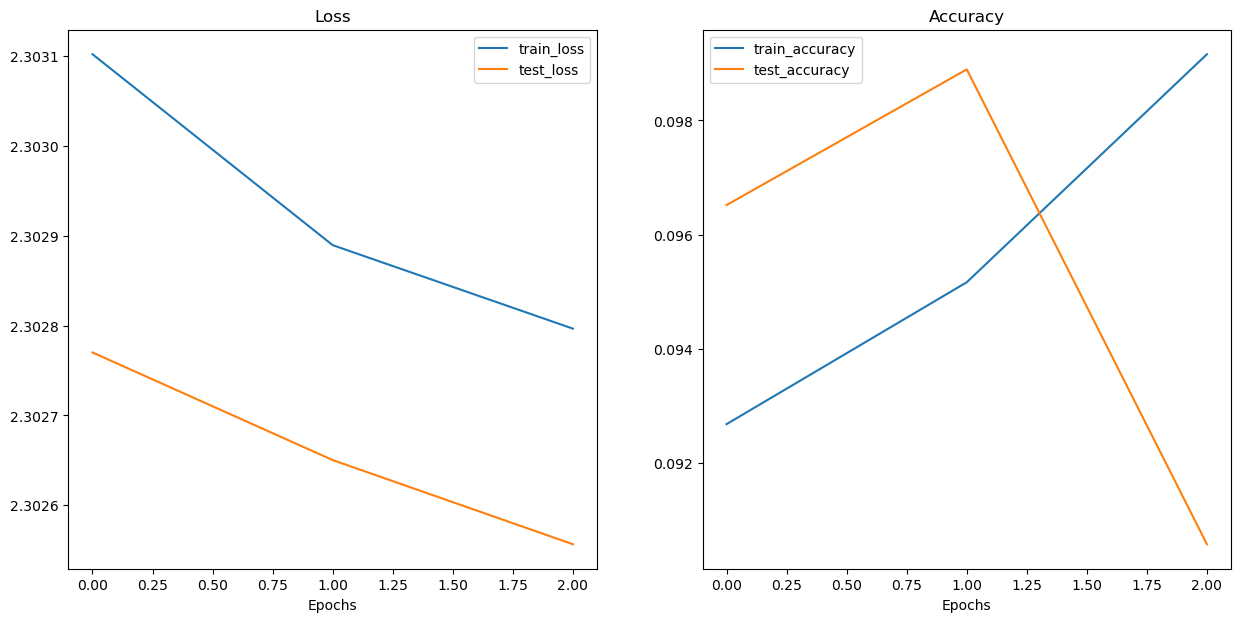

In [22]:
modelv1_4 = ModelV1(input_shape=3,
                    hidden_units=25,
                    output_shape=len(classes)).to(device)
from tqdm.auto import tqdm

results_model_v1_4 = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=modelv1_4.parameters(), lr=0.001, momentum=0.9)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=modelv1_4, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=modelv1_4, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model_v1_4["train_loss"].append(train_loss)
    results_model_v1_4["train_accuracy"].append(train_accuracy)

    results_model_v1_4["test_loss"].append(test_loss)
    results_model_v1_4["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model_v1_4)

## 4. Transfer learning

In [23]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(),  # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
    # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [24]:
train_dataset = ImageFolder(root=str(FOOD_101_PATH / "train"), transform=manual_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder(root=str(FOOD_101_PATH / "test"), transform=manual_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [26]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [27]:
BATCH_SIZE=32
train_dataset = ImageFolder(root=str(FOOD_101_PATH / "train"), transform=auto_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder(root=str(FOOD_101_PATH / "test"), transform=auto_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
summary(model, (1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]         64
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]         --
│    └─Sequential: 2-2                                  [1, 16, 128, 128]         --
│    │    └─MBConv: 3-4                                 [1, 16, 128, 128]         1,448
│    └─Sequential: 2-3                                  [1, 24, 64, 64]           --
│    │    └─MBConv: 3-5                                 [1, 24, 64, 64]           6,004
│    │    └─MBConv: 3-6                              

In [28]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(classes), bias=True)
).to(device)

In [29]:
summary(model, (1, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 10]                   --
├─Sequential: 1-1                                       [1, 1280, 8, 8]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 128, 128]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]         --
│    └─Sequential: 2-2                                  [1, 16, 128, 128]         --
│    │    └─MBConv: 3-4                                 [1, 16, 128, 128]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 64, 64]           --
│    │    └─MBConv: 3-5                                 [1, 24, 64, 64]           (6,004)
│    │    └─MBConv: 3-6                      

In [30]:
model = model.to(device)

  0%|          | 0/5 [00:00<?, ?it/s]

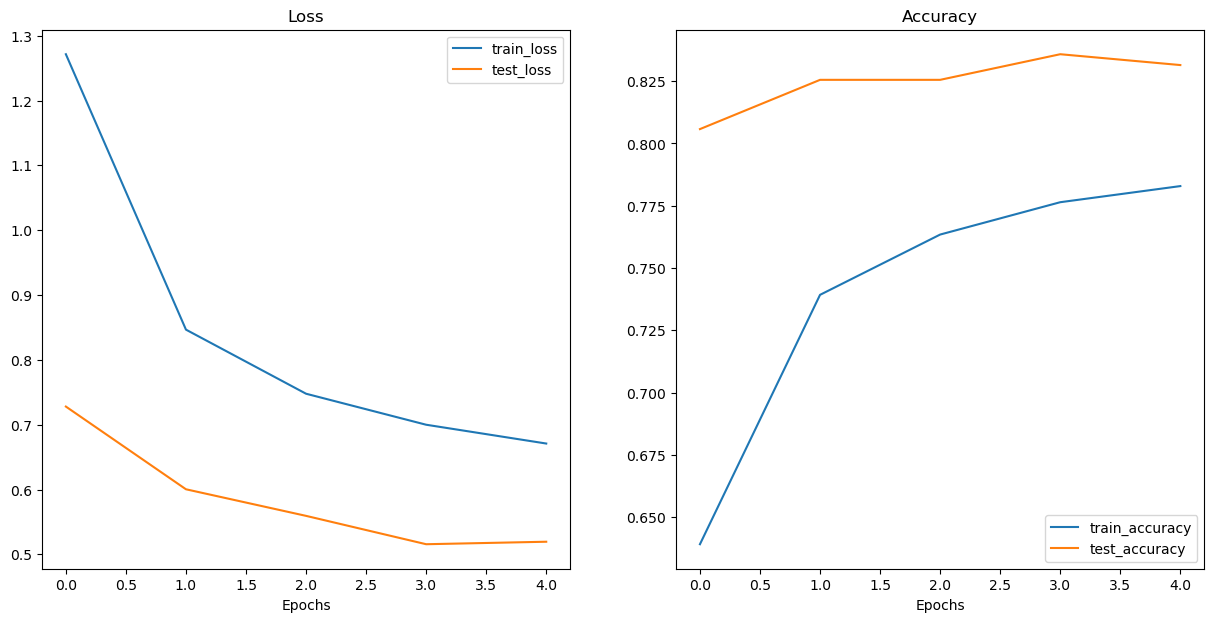

In [31]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm.auto import tqdm

results_model = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}
EPOCHS = 5
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_accuracy = helpers.train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    test_loss, test_accuracy = helpers.test_step(model=model, data_loader=test_dataloader, loss_fn=loss_fn,
                                                 device=device)

    results_model["train_loss"].append(train_loss)
    results_model["train_accuracy"].append(train_accuracy)

    results_model["test_loss"].append(test_loss)
    results_model["test_accuracy"].append(test_accuracy)

helpers.plot_loss_curves(results=results_model)

In [32]:
custom_image_path = Path("pork_chops.jpeg")
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8.shape
print(custom_image_uint8)

tensor([[[243, 243, 243,  ...,  72,  61,  77],
         [243, 243, 243,  ...,  89,  93,  95],
         [243, 243, 243,  ...,  83, 112,  88],
         ...,
         [226, 226, 225,  ..., 246, 247, 244],
         [226, 226, 225,  ..., 238, 239, 236],
         [226, 226, 225,  ..., 233, 231, 227]],

        [[243, 243, 243,  ..., 112, 101, 115],
         [243, 243, 243,  ..., 128, 129, 132],
         [243, 243, 243,  ..., 117, 144, 121],
         ...,
         [226, 226, 225,  ..., 249, 249, 243],
         [226, 226, 225,  ..., 240, 239, 233],
         [226, 226, 225,  ..., 228, 225, 218]],

        [[243, 243, 243,  ...,  16,   2,  16],
         [243, 243, 243,  ...,  39,  39,  37],
         [243, 243, 243,  ...,  43,  68,  40],
         ...,
         [226, 226, 225,  ..., 230, 228, 222],
         [226, 226, 225,  ..., 218, 211, 200],
         [226, 226, 225,  ..., 199, 191, 179]]], dtype=torch.uint8)


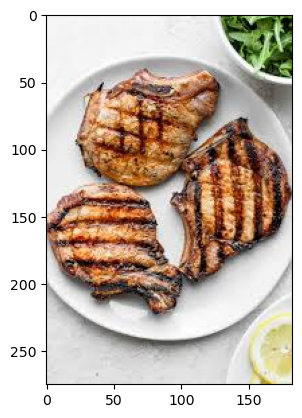

In [33]:
plt.imshow(custom_image_uint8.permute(1, 2, 0), cmap="gray")


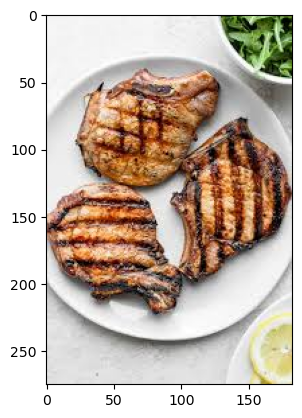

In [34]:
# Load in the custom image and convert to float32 :
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image.shape
plt.imshow(custom_image.permute(1, 2, 0))

In [35]:
custom_image_transformed = auto_transforms(custom_image)


In [36]:
model.eval()
logits = model(custom_image_transformed.unsqueeze(dim=0).to(device))
print(logits)

tensor([[ 1.0479,  1.8643, -1.4675, -1.7298, -2.8657, -0.5028,  1.9078, -0.3251,
         -3.9360, -1.6881]], device='mps:0', grad_fn=<LinearBackward0>)


In [37]:
pred_probs = torch.softmax(logits, dim=1)
print(pred_probs)

tensor([[0.1581, 0.3577, 0.0128, 0.0098, 0.0032, 0.0335, 0.3736, 0.0401, 0.0011,
         0.0102]], device='mps:0', grad_fn=<SoftmaxBackward0>)


In [38]:
y_pred_class = torch.argmax(torch.softmax(logits, dim=1), dim=1)
print(torch.max(torch.softmax(logits, dim=1), dim=1))

torch.return_types.max(
values=tensor([0.3736], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([6], device='mps:0'))


In [39]:
print(y_pred_class)

tensor([6], device='mps:0')


In [40]:
print(classes[y_pred_class])

pork_chop


In [41]:
def make_pred(image_path, model, classes, transforms, device=device):
    # Load in the custom image and convert to float32 :
    custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255
    custom_image_transformed = transforms(custom_image)

    model.eval()
    logits = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    y_pred_class = classes[torch.argmax(torch.softmax(logits, dim=1), dim=1)]
    y_pred_prob = torch.max(torch.softmax(logits, dim=1), dim=1).values
    
    plt.imshow(custom_image.permute(1, 2, 0))
    plt.title(f"{y_pred_class} | Probability: {float(y_pred_prob) : .2f}")
    plt.axis(False)
    return y_pred_class, float(y_pred_prob)


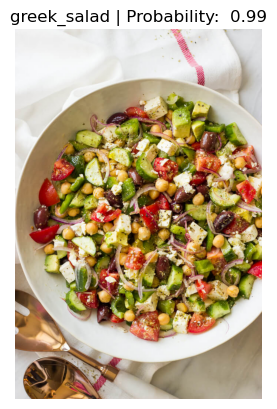

In [42]:
custom_image_path = Path("Chopped-Greek-Salad-with-Avocado-14.jpg")
pred, pred_prob = make_pred(image_path=custom_image_path, model=model, classes=classes, transforms=auto_transforms, device=device)

In [43]:
torch.save(model.state_dict(), "model.pth")

In [44]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

In [45]:
model2 = torchvision.models.efficientnet_b0().to(device)

model2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=len(classes), bias=True)
).to(device)

In [46]:
model2.load_state_dict(state_dict=torch.load("model.pth"))

<All keys matched successfully>

('greek_salad', 0.9869988560676575)

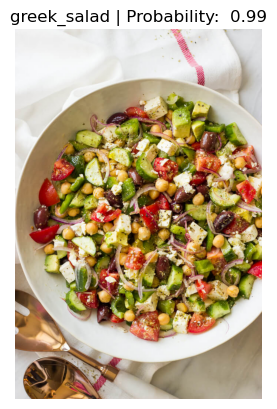

In [47]:
make_pred("Chopped-Greek-Salad-with-Avocado-14.jpg", model=model2, classes=classes, transforms=auto_transforms, device=device)
